# Multi-agent Collaboration Intro

A single agent can usually operate effectively using a handful of tools and a scoped domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. One way to improve your system's performance is through multi-agent collaboration. Each agent can specialize in a task or domain, and LangGraph can effectively orchestrate them to accomplish a larger goal. 

This notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.

In [ ]:
%pip install -U langchain langchain_openai langsmith pandas

In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

## Example 1: 2 Agents

Below is an example of 2 agents collaborating to accomplish a single task.

In [16]:
import uuid
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
from langchain_core.tools import tool

USER_DATA = [
    {
        "id": 1,
        "name": "Alice",
        "email": "alice@gmail.com",
        "favorite_color": "red",
        "favorite_foods": [1, 2, 3],
    },
    {
        "id": 21,
        "name": "Bob",
        "email": "bob@hotmail.com",
        "favorite_color": "orange",
        "favorite_foods": [4, 5, 6],
    },
    {
        "id": 35,
        "name": "Charlie",
        "email": "charlie@yahoo.com",
        "favorite_color": "yellow",
        "favorite_foods": [3, 7, 2],
    },
    {
        "id": 41,
        "name": "Donna",
        "email": "donna@example.com",
        "favorite_color": "green",
        "favorite_foods": [6, 1, 4],
    },
    {
        "id": 42,
        "name": "Eve",
        "email": "eve@example.org",
        "favorite_color": "blue",
        "favorite_foods": [5, 7, 4],
    },
    {
        "id": 43,
        "name": "Frank The Cat",
        "email": "frank.the.cat@langchain.dev",
        "favorite_color": "yellow",
        "favorite_foods": [3],
    },
]

FOOD_DATA = [
    {
        "id": 1,
        "name": "Pizza",
        "calories": 285,  # Calories per serving
        "allergic_ingredients": ["Gluten", "Dairy"],
    },
    {
        "id": 2,
        "name": "Chocolate",
        "calories": 50,  # Calories per serving
        "allergic_ingredients": ["Milk", "Soy"],
    },
    {
        "id": 3,
        "name": "Sushi",
        "calories": 300,  # Calories per serving
        "allergic_ingredients": ["Fish", "Soy"],
    },
    {
        "id": 4,
        "name": "Burger",
        "calories": 350,  # Calories per serving
        "allergic_ingredients": ["Gluten", "Dairy"],
    },
    {
        "id": 5,
        "name": "Ice Cream",
        "calories": 200,  # Calories per serving
        "allergic_ingredients": ["Dairy"],
    },
    {
        "id": 6,
        "name": "Pasta",
        "calories": 180,  # Calories per serving
        "allergic_ingredients": ["Gluten"],
    },
    {
        "id": 7,
        "name": "Salad",
        "calories": 50,  # Calories per serving
        "allergic_ingredients": [],
    },
]


@tool
def list_users() -> List[str]:
    """Return a list of all the user names."""
    return [user_info["name"] for user_info in USER_DATA]


@tool
def get_user_favorite_food_ids(user_id: int) -> List[int]:
    """Get the favorite foods of the user with the provided ID."""
    for user_info in USER_DATA:
        if user_info["id"] == user_id:
            return user_info["favorite_foods"]
    raise ValueError(f"Id: {user_id} not found.")


@tool
def get_food_name(food_id: int) -> str:
    """Get the food name."""
    for food_info in FOOD_DATA:
        if food_info["id"] == food_id:
            return food_info["name"]
    raise ValueError(f"Id: {food_id} not found.")


@tool
def get_user_id(user_name: str) -> int:
    """Return the ID of the provided user name."""
    for user_info in USER_DATA:
        if user_info["name"] == user_name:
            return user_info["id"]
    raise ValueError(f"Name: {user_name} not found.")


@tool
def create_barplot(
    data: Union[List[float], List[int]],
    labels: Union[List[str], None] = None,
    title: str = "Bar Plot",
    xlabel: str = "X",
    ylabel: str = "Y",
    color: Union[str, List[str]] = "blue",
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Generates a bar plot from the provided data and returns the figure and axis objects.

    :param data: A list of numerical values for the bar heights.
    :param labels: A list of strings for the bar labels. Default is None.
    :param title: Title of the plot. Default is 'Bar Plot'.
    :param xlabel: Label for the X-axis. Default is 'X'.
    :param ylabel: Label for the Y-axis. Default is 'Y'.
    :param color: Color of the bars. Can be a single color or a list of colors. Default is 'blue'.
    :param figsize: Size of the figure as a tuple (width, height). Default is (10, 6).
    :return: Tuple containing the figure and axes objects.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    x_positions = range(len(data))

    if labels and len(labels) == len(data):
        plt.xticks(x_positions, labels)

    ax.bar(x_positions, data, color=color)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.savefig("./plot.png")
    return "./plot.png"

In [17]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain.agents import create_openai_functions_agent
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [18]:
workflow = StateGraph(AgentState)

# This a helper class we have that is useful for running tools
# It takes in an agent action and calls that tool and returns the result
tools = [
    list_users,
    get_user_favorite_food_ids,
    get_food_name,
    get_user_id,
    create_barplot,
]
tool_executor = ToolExecutor(tools)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful AI assistant, collaborating with other assistants."
            " Use the provided tools to progress towards answering the question."
            " If you are unable to fully answer, that's OK, another assistant with different tools "
            " will help where you left off. Execute what you can to "
            " If you have the final answer, prefix your response with FINAL ANSWER:",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


def add_agent_node(name: str, llm, tools, prompt):
    functions = [format_tool_to_openai_function(t) for t in tools]
    chain = (
        (lambda x: {**x, "intermediate_steps": []})
        | prompt
        | llm.bind_functions(functions)
        | (lambda x: {"messages": [x], "sender": name})
    )
    workflow.add_node(name, chain)


def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        ),
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}


def should_continue(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "end"
    return "continue"


llm = ChatOpenAI(model="gpt-4")
add_agent_node(
    "user_info",
    llm,
    [
        list_users,
        get_user_favorite_food_ids,
        get_food_name,
        get_user_id,
    ],
    prompt,
)
add_agent_node("plot_bars", llm, [create_barplot], prompt)
workflow.add_node("call_tool", call_tool)
workflow.add_conditional_edges(
    "user_info",
    should_continue,
    {"continue": "plot_bars", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "plot_bars",
    should_continue,
    {"continue": "user_info", "call_tool": "call_tool", "end": END},
)
# We will let the user_info tool decide when to respond.
workflow.add_edge("call_tool", "user_info")
workflow.set_entry_point("user_info")
graph = workflow.compile()

{'messages': [HumanMessage(content='Draw a bar plot of the favorite foods of Eve and Donna'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "user_name": "Eve"\n}', 'name': 'get_user_id'}}),
  FunctionMessage(content='42', name='get_user_id'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "user_id": 42\n}', 'name': 'get_user_favorite_food_ids'}}),
  FunctionMessage(content='[5, 7, 4]', name='get_user_favorite_food_ids'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "food_id": 5\n}', 'name': 'get_food_name'}}),
  FunctionMessage(content='Ice Cream', name='get_food_name'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "food_id": 7\n}', 'name': 'get_food_name'}}),
  FunctionMessage(content='Salad', name='get_food_name'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "food_id": 4\n}', 'name': 'get_food_name'}}),
  Function

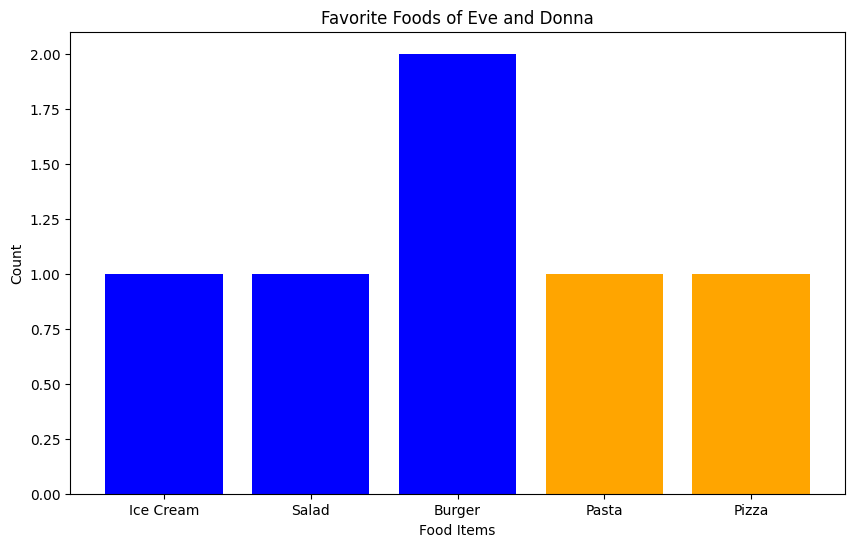

In [19]:
result = graph.invoke(
    {
        "messages": [
            HumanMessage(
                content="Draw a bar plot of the favorite foods of Eve and Donna"
            )
        ]
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
result["messages"][-1]